<a href="https://colab.research.google.com/github/WesleyAldridge/HW3_MachineLearning/blob/master/HW3_MachineLearning_Problem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 4

##Build an activation model that takes as input an image and produces as output the activation of the last conv layer of the model obtained in Problem 2. Using this activation model obtain the corresponding activations for the validation images. Apply t-SNE visualization to these activations to see how well the convnet separates cats from dogs.

### Retrieving cats_and_dogs data, creating directories

In [1]:
import cv2

from google.colab import files
from google.colab.patches import cv2_imshow

from keras import backend as K
from keras import models, layers, optimizers
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects

import numpy as np

import os

import seaborn as sns

from sklearn.manifold import TSNE

import time

import zipfile

Using TensorFlow backend.


### Loading image data

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

--2019-04-18 02:56:26--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  89.9MB/s    in 0.7s    

2019-04-18 02:56:27 (89.9 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### Recreating model from problem 2 because I get an error when I try to use load_model()

In [3]:
conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
    
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc']
)


history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Instructions for updating:
Colocations handled automatically by placer.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 43s 425ms/step - loss: 0.5123 - acc: 0.7270 - val_loss: 0.2751 - val_acc: 0.8740
Epoch 2/30
100/100 [==============================] - 31s 310ms/step - loss: 0.3429 - acc: 0.8470 - val_loss: 0.3021 - val_acc: 0.8750
Epoch 3/30
100/100 [==============================] - 32s 317ms/step - loss: 0.2943 - acc: 0.8770 - val_loss: 0.3970 - val_acc: 0.8460
Epoch 4/30
100/100 [==============================] - 34s 336ms/step - loss: 0.2637 - acc: 0.8890 - val_loss: 0.1919 - val_acc: 0.9190
Epoch 5/30
100/100 [==============================] - 33s 329ms/step - loss: 0.2460 - acc: 0.8940 - val_loss: 0.2919 - val_acc: 0.8990
Epoch 6/30
100/100 [==============================] - 33s 330ms/step - loss: 0.2103 - acc: 0.9165 - val_loss: 0.2373 - va

### Summary

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 11,536,897
Non-trainable params: 10,585,152
_________________________________________________________________


In [11]:
layer = model.get_layer('dense_1')
layer_output = layer.output

activation_model = models.Model(input=model.input, outputs=[layer_output])
activations = activation_model.predict_generator(validation_generator, steps=25)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("vg...)`
  after removing the cwd from sys.path.


In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 1000 images belonging to 2 classes.


In [0]:
def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    colors = ["#00b5c4", "#ff9929"]
    palette = np.array(sns.color_palette(colors))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')


    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

t-SNE done! Time elapsed: 2.7403109073638916 seconds


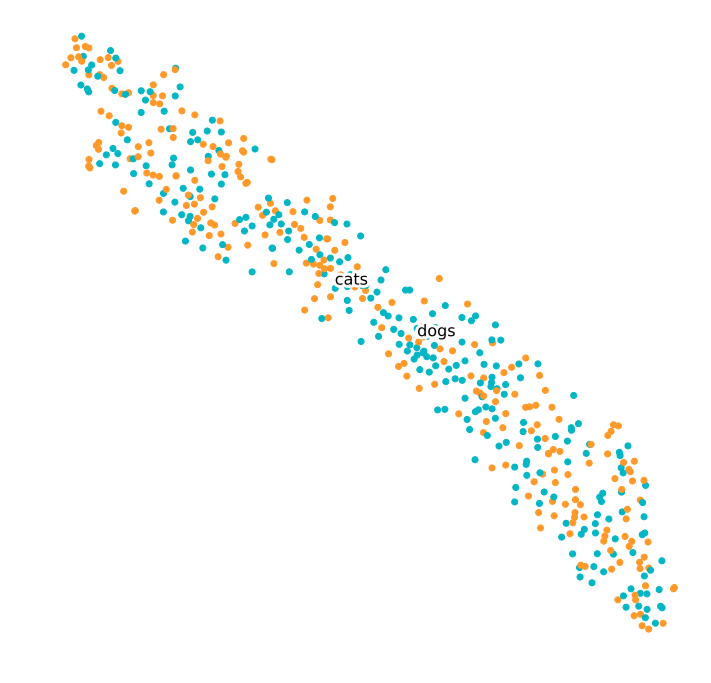

In [14]:
time_start = time.time()

tsne = TSNE(random_state=42).fit_transform(activations)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

labels = validation_generator.classes
np.random.shuffle(labels)
labels = labels[:500]
class_names = ['dogs', 'cats']
data_scatter(tsne, labels)